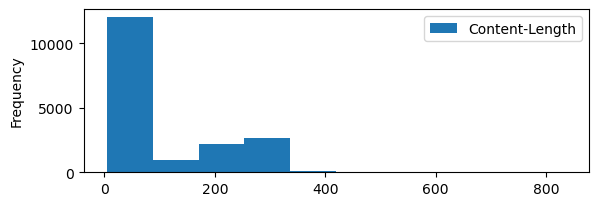

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_url = './csicFinal.csv'
data = pd.read_csv(data_url)

# Drop de colunas contem os mesmos valores (redundantes)
redundant_columns = ['Pragma', 'Host-Header', 'Connection', 'Accept', 'Accept-Charset', 'Accept-Language', 'Cache-control']
for var in redundant_columns:
    data.drop(var, axis = 1, inplace = True)


# Remocao Cookies: Apos observar no terminal usando a funcao
# print(data['Cookie'].value_counts())
# Percebe-se que cada coluna contem um valor de cookie diferente.
# Como cada coluna tem um valor de Cookie diferente para cada uma, me parece mais ser um identificador
# Ou seja, uma variavel que nao ira ajudar em detectar ser uma anomalia ou nao, optando por remove-la
data.drop('Cookie', axis = 1, inplace = True)



In [ ]:
# Conversao variaveis categoricas em numericas para
from sklearn.preprocessing import OneHotEncoder

one_hot_enconder_columns = OneHotEncoder()

# One Hot Enconder

# feature_array recebe matriz com a encodificacao one hot
columns_to_OHE = ["Method", "Host", "Class"]
feature_array = one_hot_enconder_columns.fit_transform(data[columns_to_OHE]).toarray()

# feature_labels recebe as categorias da matriz criada
feature_labels = one_hot_enconder_columns.categories_

# Concatena as categorias de todas as colunas
concatenated_categories = np.concatenate(feature_labels)

# DataFrame com as colunas de categorias + matriz de dados OHE
df_OHE = pd.DataFrame(feature_array, columns=concatenated_categories)

# Concatenacao dos dados com OHE
data_with_OHE = pd.concat([data, df_OHE], axis = 1)


# Remocao das colunas com valores categoricos
for var in columns_to_OHE:
    data_with_OHE.drop(var, axis = 1, inplace = True)

#display(data_with_OHE)

#for var in data_with_OHE.columns:
 #   display('Coluna analisada: ', var, data_with_OHE[var].unique(), '--------------------')


In [66]:
y_columns = ['Valid', 'Anomalous']
X = data_with_OHE.drop(y_columns, axis = 1)
y = data_with_OHE[y_columns]

In [67]:
from sklearn.model_selection import train_test_split
                                                        #20% de dados para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

In [ ]:
## Engenharia de features e feature scalling
# Identificar os valores nulos das features e estabelecer um valor de media para eles
# auxiliando no apredizado de maquina.
# Feature Scaling ira normalizar o intervalo dos recursos usados, tornado mais "uniformes"

In [70]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors='?')

knn.fit(X_train, y_train)

y_predict = knn.predict(X_test)

ValueError: could not convert string to float: '/tienda1/publico/entrar.jsp'